In [1]:
import os, sys, re
import numpy as np
import pandas as pd
import platform
from IPython.display import display, clear_output, HTML
from datetime import datetime
import pickle

from time import sleep
from tqdm.auto import tqdm

import selenium
from selenium.webdriver.common.by import By
from selenium.webdriver import Firefox, ActionChains

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

START_TS = datetime.now()

In [2]:
from utils import get_all_elements, iou_xywh, screenshot, maximize_window, get_parents_list, build_tree_dict

2021-02-27 01:26:58,199 - INFO - dataset:dataset.py:17 - dataset loaded...


In [3]:
selenium.__version__

'3.141.0'

## Parameters

In [4]:
SITE_ROOT = 'https://jdi-testing.github.io/jdi-light/'
LOGIN = 'Roman'
PASSWORD = 'Jdi1234'
SAVE_SCREEN = True
WAIT_TIME_SECONDS = 7
HEADLESS = True #False


## Create driver (HEADLESS={True|False})

In [5]:
from selenium.webdriver.chrome.options import Options
options = Options()
options.add_argument('--disable-gpu')  # Last I checked this was necessary.
options.add_argument('--headless')

CHROME_DRIVER_PATH = os.path.join(os.getcwd(), 'chromedriver.exe')
if os.path.exists(CHROME_DRIVER_PATH):
    driver = selenium.webdriver.Chrome(executable_path=CHROME_DRIVER_PATH, options=options)
    driver.get(SITE_ROOT)


In [6]:
driver.get_window_position(), driver.get_window_size(), driver.title

({'x': 0, 'y': 0}, {'width': 800, 'height': 600}, 'Home Page')

In [7]:
re.findall('<[A-Za-z]+ [^<>]*>', driver.page_source)

['<html lang="en">',
 '<meta charset="utf-8">',
 '<meta http-equiv="X-UA-Compatible" content="IE=edge">',
 '<meta name="viewport" content="width=device-width">',
 '<link rel="stylesheet" href="bootstrap/css/bootstrap.min.css">',
 '<link rel="stylesheet" href="css/uui-all.css">',
 '<link rel="stylesheet" href="css/custom-styles.css">',
 '<link rel="stylesheet" href="fonts/font-awesome/css/font-awesome.min.css">',
 '<link rel="stylesheet" href="css/lib/components/jquery.mCustomScrollbar.css">',
 '<script src="js/lib/jquery-1.11.1.min.js">',
 '<script src="js/lib/components/jquery.mCustomScrollbar.concat.min.js">',
 '<script src="js/lib/jquery.cookie.js">',
 '<script src="bootstrap/js/bootstrap.min.js">',
 '<script src="js/uui-core.min.js" type="text/javascript">',
 '<script src="js/utils.js" type="text/javascript">',
 '<script src="js/lib/html5shiv.js">',
 '<script src="js/lib/respond.min.js">',
 '<div class="uui-header dark-gray">',
 '<nav role="navigation">',
 '<div class="sidebar-togg

In [8]:
[(e.tag_name, e.is_displayed(), e.id) for e in driver.find_elements_by_xpath('//*') if e.tag_name == 'span']

[('span', False, '4c69f710-cbf6-407e-b22b-fe78225f7051'),
 ('span', True, '80fd4b23-768c-4b24-8f53-f03d863c24a2'),
 ('span', True, 'e42e36d1-4f59-433d-83cf-e1f608f1922e'),
 ('span', False, 'b086ef66-ece7-413f-b869-50e9fd3169f8'),
 ('span', True, '9e1fd09f-5650-40e0-af3a-f126d53d1d00'),
 ('span', False, 'f58bf9b0-45e5-4fd7-ad1e-80beeb332e6c'),
 ('span', False, '73b1763a-0c4f-4c84-9e85-9555d597e60d'),
 ('span', False, 'd52301ca-2329-497a-af70-53736e1e3917'),
 ('span', True, '8dbf55e8-6ce9-4c08-bb92-eb054c961874'),
 ('span', False, 'da675a59-18b2-42ef-9a68-a2690b3d7830'),
 ('span', False, 'cc39ab89-07b2-43a2-891e-73b15e9cf4bd'),
 ('span', True, '09b4c2f1-9ec3-4fa1-b3b1-ade2f228e158'),
 ('span', True, '4499a44c-2b04-4d33-a1fe-f0a7383d8388'),
 ('span', True, 'aaa32b7d-12ee-435d-8a81-e2853d48f562'),
 ('span', False, '0fb1a780-a8a5-4de5-88d3-2e391386587f'),
 ('span', False, '3cd65ecc-37e6-4a78-aef5-2656a449dc6b'),
 ('span', False, 'c2e878af-e22d-4c79-9b43-f8bfeca4d5fb'),
 ('span', False, '07e

In [9]:
e = [e for e in driver.find_elements_by_xpath('//*') if e.tag_name == 'span'][1]

In [10]:
import io

In [11]:
buf = io.BytesIO(e.screenshot_as_png)

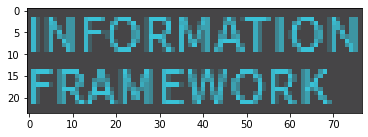

In [12]:
plt.imshow(plt.imread(buf))

In [13]:
driver.close()

In [14]:
os.makedirs('dataset/images', exist_ok=True)
os.makedirs('dataset/df', exist_ok=True)
os.makedirs('dataset/annotations', exist_ok=True)
os.makedirs('dataset/html', exist_ok=True)


## Setup (init web driver, login)

In [15]:
def setup_web_driver():
    
    options = Options()
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')

    CHROME_DRIVER_PATH = os.path.join(os.getcwd(), 'chromedriver.exe')
    if os.path.exists(CHROME_DRIVER_PATH):
        driver = selenium.webdriver.Chrome(executable_path=CHROME_DRIVER_PATH, options=options)
        driver.get(SITE_ROOT)
    
    driver.find_element_by_id("user-icon").click()
    driver.find_element_by_id("name").send_keys(LOGIN)
    driver.find_element_by_id("password").send_keys(PASSWORD)
    driver.find_element_by_id("login-button").click()
    sleep(WAIT_TIME_SECONDS)
        
    return driver
    

2021-02-27 01:27:53,219 - INFO - common:common.py:82 - Window maximized
Number of discovered elements: 228


  0%|          | 0/228 [00:00<?, ?it/s]

,parent_id,element_id,tag_name,x,y,height,width,displayed,enabled,selected,text,is_hover,base64png_before_hover,base64png_after_hover,attr_class,attr_onclick,attr_type,attr_role,attr_id
0,None,329aede5-0265-4760-86c7-009b76c67f4c,html,0,0,1319,1183,True,True,False,None,False,None,None,,None,None,None,
1,329aede5-0265-4760-86c7-009b76c67f4c,68aaf57a-440d-44de-b050-91842f290b28,head,17,0,0,0,False,True,False,None,False,None,None,,None,None,None,
2,68aaf57a-440d-44de-b050-91842f290b28,bd106201-353f-44d4-ad40-6d3cf8f1d74b,meta,17,0,0,0,False,True,False,None,False,None,None,,None,None,None,
3,68aaf57a-440d-44de-b050-91842f290b28,1a59bbfe-9af4-42d3-8fd8-5e6510882561,title,17,0,0,0,False,True,False,Home Page,False,None,None,,None,None,None,
4,68aaf57a-440d-44de-b050-91842f290b28,408292cb-238b-494a-ac56-0d6c51414172,meta,17,0,0,0,False,True,False,None,False,None,None,,None,None,None,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,d344972a-c06c-40fb-bcec-7b35237b2965,55f584ff-9748-4fa8-a42a-1f66700d8e07,li,1098,1297,15,3,True,True,False,None,False,iVBORw0KGgoAAAANSUhEUgAAAAMAAAAPCAYAAAAh6nXEAA...,iVBORw0KGgoAAAANSUhEUgAAAAMAAAAPCAYAAAAh6nXEAA...,,None,,None,
224,d344972a-c06c-40fb-bcec-7b35237b2965,0130a563-a022-44cf-8997-1f2042e1ef39,li,1116,1297,15,64,True,True,False,None,True,iVBORw0KGgoAAAANSUhEUgAAAEAAAAAPCAYAAABUZ8lnAA...,iVBORw0KGgoAAAANSUhEUgAAAEAAAAAPCAYAAABUZ8lnAA...,,None,,None,
225,0130a563-a022-44cf-8997-1f2042e1ef39,6394d73b-13e1-4520-b7c0-d8ef698c1ed7,a,1116,1297,15,64,True,True,False,Report a bug,True,iVBORw0KGgoAAAANSUhEUgAAAEAAAAAPCAYAAABUZ8lnAA...,iVBORw0KGgoAAAANSUhEUgAAAEAAAAAPCAYAAABUZ8lnAA...,,None,,None,
226,df94bd83-e8a5-4ba5-91b9-cc640851f14c,86329608-7ef0-4120-834e-772be97c66c2,script,17,17,18,223,False,True,False,"\n UUI.Vertical_Menu.init({""open"": true...",False,None,None,,None,,None,


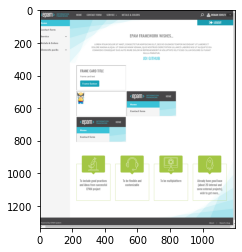

In [16]:
with setup_web_driver() as driver:
    maximize_window(driver=driver)
    plt.imshow(screenshot(driver, save_to_file='dataset/images/login.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/login.parquet')
    with open('dataset/html/login.html', 'w') as f:
        f.write(driver.page_source)
        f.flush()
    
    
display(elements_df)


In [22]:
tree_dict = build_tree_dict(elements_df)
tag_name_dict = dict(zip(elements_df.element_id.values, elements_df.tag_name))
width_dict = dict(zip(elements_df.element_id.values, elements_df.width))
height_dict = dict(zip(elements_df.element_id.values, elements_df.height))


In [25]:
for i, r in elements_df.iterrows():
    list_of_parents = []
    path = []
    get_parents_list(tree_dict=tree_dict, element_id= r.element_id, paternts_list=list_of_parents)
    path = "/".join([ 
        tag_name_dict[i]+':'+str(int(width_dict[i])) +':'+str(int(height_dict[i])) 
        for i in get_parents_list(tree_dict=tree_dict, element_id=r.element_id, paternts_list=path)])
    print(path)


html:1183:1319
head:0:0/html:1183:1319
head:0:0/html:1183:1319
head:0:0/html:1183:1319
head:0:0/html:1183:1319
head:0:0/html:1183:1319
head:0:0/html:1183:1319
head:0:0/html:1183:1319
head:0:0/html:1183:1319
head:0:0/html:1183:1319
head:0:0/html:1183:1319
head:0:0/html:1183:1319
head:0:0/html:1183:1319
head:0:0/html:1183:1319
head:0:0/html:1183:1319
head:0:0/html:1183:1319
html:1183:1319
body:1200:1336/html:1183:1319
header:1200:60/body:1200:1336/html:1183:1319
div:1200:60/header:1200:60/body:1200:1336/html:1183:1319
nav:1200:0/div:1200:60/header:1200:60/body:1200:1336/html:1183:1319
div:60:60/nav:1200:0/div:1200:60/header:1200:60/body:1200:1336/html:1183:1319
div:0:0/div:60:60/nav:1200:0/div:1200:60/header:1200:60/body:1200:1336/html:1183:1319
nav:1200:0/div:1200:60/header:1200:60/body:1200:1336/html:1183:1319
div:215:60/nav:1200:0/div:1200:60/header:1200:60/body:1200:1336/html:1183:1319
a:86:18/div:215:60/nav:1200:0/div:1200:60/header:1200:60/body:1200:1336/html:1183:1319
span:77:24/

a:0:0/li:0:0/ul:0:0/li:200:39/ul:200:203/div:200:213/div:200:213/div:200:213/div:200:1212/div:200:1212/div:1200:1212/body:1200:1336/html:1183:1319
ul:0:0/li:200:39/ul:200:203/div:200:213/div:200:213/div:200:213/div:200:1212/div:200:1212/div:1200:1212/body:1200:1336/html:1183:1319
li:0:0/ul:0:0/li:200:39/ul:200:203/div:200:213/div:200:213/div:200:213/div:200:1212/div:200:1212/div:1200:1212/body:1200:1336/html:1183:1319
a:0:0/li:0:0/ul:0:0/li:200:39/ul:200:203/div:200:213/div:200:213/div:200:213/div:200:1212/div:200:1212/div:1200:1212/body:1200:1336/html:1183:1319
ul:0:0/li:200:39/ul:200:203/div:200:213/div:200:213/div:200:213/div:200:1212/div:200:1212/div:1200:1212/body:1200:1336/html:1183:1319
li:0:0/ul:0:0/li:200:39/ul:200:203/div:200:213/div:200:213/div:200:213/div:200:1212/div:200:1212/div:1200:1212/body:1200:1336/html:1183:1319
a:0:0/li:0:0/ul:0:0/li:200:39/ul:200:203/div:200:213/div:200:213/div:200:213/div:200:1212/div:200:1212/div:1200:1212/body:1200:1336/html:1183:1319
div:200:2

In [17]:
elements_df.attr_class.unique()

array(['', 'uui-header dark-gray', 'sidebar-toggle-box blue',
       'sidebar-tooltip', 'fa fa-reorder', 'epam-logo',
       'uui-navigation nav navbar-nav m-l8', 'dropdown',
       'dropdown-toggle', 'caret', 'dropdown-menu',
       'uui-navigation navbar-nav navbar-right',
       'dropdown uui-profile-menu open', 'profile-photo',
       'dropdown-menu dropdown-menu-login',
       'form-horizontal login hidden', 'form-horizontal-pad',
       'form-group form-group10', 'col-sm-3', 'col-sm-9',
       'uui-form-element', 'login-txt hidden',
       'uui-button dark-blue btn-login', 'fa fa-sign-in', 'logout',
       'fa fa-sign-out', 'search', 'icon-search', 'search-active hidden',
       'search-title', 'icon-search active', 'search-field', 'wrapper',
       'uui-side-bar mCustomScrollbar _mCS_1 mCS_no_scrollbar',
       'mCustomScrollBox mCS-light mCSB_vertical mCSB_inside',
       'mCSB_container mCS_y_hidden mCS_no_scrollbar_y', 'sidebar-menu',
       'active', 'menu-title', 'fa fa-car

In [18]:
elements_df.attr_role.unique()

array([None, 'navigation', 'menu'], dtype=object)

In [19]:
elements_df.attr_onclick.unique()

array([None, "window.open('search.html','_self')"], dtype=object)

In [20]:
elements_df.attr_type.unique()

array([None, '', 'text/javascript', 'text', 'password', 'submit'],
      dtype=object)

# Save pages & screenshots

- ## HTML 5

Window maximized
Number of discovered elements: 662


  0%|          | 0/662 [00:00<?, ?it/s]

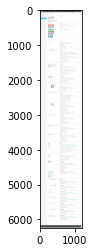

In [21]:
with setup_web_driver() as driver:
      
    driver.find_element(By.LINK_TEXT, "Elements packs").click()
    driver.find_element(By.LINK_TEXT, "HTML 5").click()
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/html-5.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/html-5.parquet')
    with open('dataset/html/html-5.html', 'w') as f:
        f.write(driver.page_source)
        f.flush()
    



- ## Contact form

Window maximized
Number of discovered elements: 336


  0%|          | 0/336 [00:00<?, ?it/s]

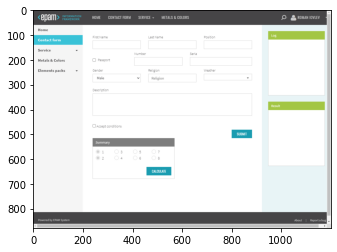

In [22]:
with setup_web_driver() as driver:
      
    driver.find_element(By.LINK_TEXT, "Contact form").click()
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/contact-form.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/contact-form.parquet')
    with open('dataset/html/contact-form.html', 'w') as f:
        f.write(driver.page_source)
        f.flush()
    


- ## Mobile and HTML 5

Window maximized
Number of discovered elements: 647


  0%|          | 0/647 [00:00<?, ?it/s]

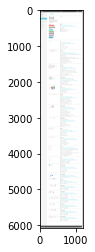

In [23]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Elements packs").click()
    driver.find_element_by_link_text("Mobile and HTML 5").click()
    sleep(WAIT_TIME_SECONDS)
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/mobile-and-html-5.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/mobile-and-html-5.parquet')
    with open('dataset/html/mobile-and-html-5.html', 'w') as f:
        f.write(driver.page_source)
        f.flush()
    


- ## Bootstrap

Window maximized
Number of discovered elements: 1095


  0%|          | 0/1095 [00:00<?, ?it/s]

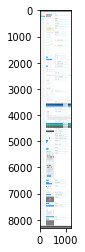

In [24]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Elements packs").click()
    driver.find_element_by_link_text("Bootstrap").click()
    sleep(WAIT_TIME_SECONDS)
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/bootstrap.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/bootstrap.parquet')
    
    with open('dataset/html/bootstrap.html', 'w') as f:
        f.write(driver.page_source)
        f.flush()


- ## React Ant

Window maximized
Number of discovered elements: 700


  0%|          | 0/700 [00:00<?, ?it/s]

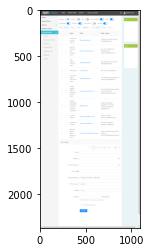

In [25]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Elements packs").click()
    driver.find_element_by_link_text("React Ant").click()
    sleep(WAIT_TIME_SECONDS)
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/react-ant.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/react-ant.parquet')

    with open('dataset/html/react-ant.html', 'wb') as f:
        f.write(driver.page_source.encode())
        f.flush()
    
  


- ## Metals & Colors

Window maximized
Number of discovered elements: 373


  0%|          | 0/373 [00:00<?, ?it/s]

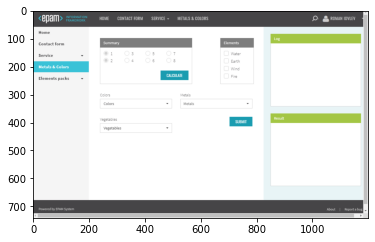

In [26]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Metals & Colors").click()
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/metals-and-colors.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/metals-and-colors.parquet')
    
    with open('dataset/html/metals-and-colors.html', 'wb') as f:
        f.write(driver.page_source.encode())
        f.flush()
    


- ## Service / Support

Window maximized
Number of discovered elements: 284


  0%|          | 0/284 [00:00<?, ?it/s]

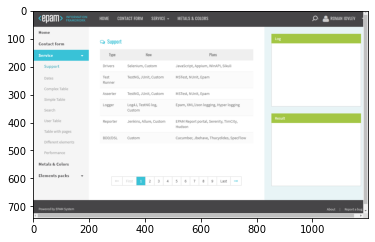

In [27]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Service").click()
    driver.find_element_by_link_text("Support").click()
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/support.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/support.parquet')
    
    with open('dataset/html/support.html', 'wb') as f:
        f.write(driver.page_source.encode())
        f.flush()
    


- ## Service / Dates

Window maximized
Number of discovered elements: 313


  0%|          | 0/313 [00:00<?, ?it/s]

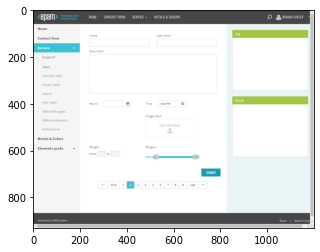

In [28]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Service").click()
    driver.find_element_by_link_text("Dates").click()
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/dates.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/dates.parquet')
    
    with open('dataset/html/dates.html', 'wb') as f:
        f.write(driver.page_source.encode())
        f.flush()
    


- ## Service / Complex Table

Window maximized
Number of discovered elements: 423


  0%|          | 0/423 [00:00<?, ?it/s]

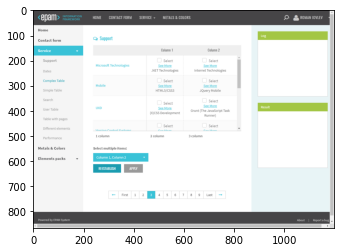

In [29]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Service").click()
    driver.find_element_by_link_text("Complex Table").click()
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/complex-table.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/complex-table.parquet')
    
    with open('dataset/html/complex-table.html', 'wb') as f:
        f.write(driver.page_source.encode())
        f.flush()
    


- ## Service / Search

Window maximized
Number of discovered elements: 294


  0%|          | 0/294 [00:00<?, ?it/s]

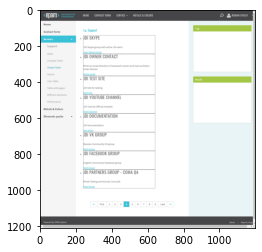

In [30]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Service").click()
    driver.find_element_by_link_text("Search").click()
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/search.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/search.parquet')
    
    with open('dataset/html/search.html', 'wb') as f:
        f.write(driver.page_source.encode())
        f.flush()
    


- ## Service / User Table

Window maximized
Number of discovered elements: 366


  0%|          | 0/366 [00:00<?, ?it/s]

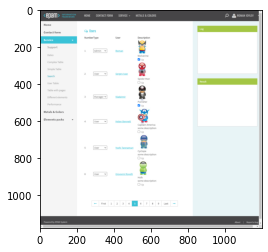

In [31]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Service").click()
    driver.find_element_by_link_text("User Table").click()
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/user-table.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/user-table.parquet')
    
    with open('dataset/html/user-table.html', 'wb') as f:
        f.write(driver.page_source.encode())
        f.flush()
    


- ## Service / Table with pages

Window maximized
Number of discovered elements: 309


  0%|          | 0/309 [00:00<?, ?it/s]

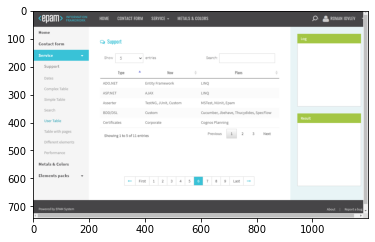

In [32]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Service").click()
    driver.find_element_by_link_text("Table with pages").click()
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/table-with-pages.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/table-with-pages.parquet')
    
    with open('dataset/html/table-with=pages.html', 'wb') as f:
        f.write(driver.page_source.encode())
        f.flush()
    


- ## Service / Different elements

Window maximized
Number of discovered elements: 289


  0%|          | 0/289 [00:00<?, ?it/s]

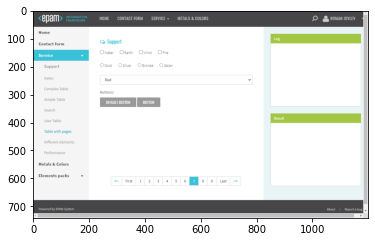

In [33]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Service").click()
    driver.find_element_by_link_text("Different elements").click()
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/different-elements.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/different-elements.parquet')
    
    with open('dataset/html/different-elemants.html', 'wb') as f:
        f.write(driver.page_source.encode())
        f.flush()
    


- ## Service / Performance

Window maximized
Number of discovered elements: 2672


  0%|          | 0/2672 [00:00<?, ?it/s]

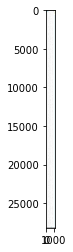

In [34]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Service").click()
    driver.find_element_by_link_text("Performance").click()
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/performance.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/performance.parquet')
    
    with open('dataset/html/performance.html', 'wb') as f:
        f.write(driver.page_source.encode())
        f.flush()
    


- ## Angular

Window maximized
(44802, 1200, 4)
Number of discovered elements: 6447


  0%|          | 0/6447 [00:00<?, ?it/s]

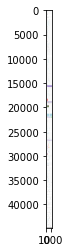

In [35]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Elements packs").click()
    driver.find_element_by_link_text("Angular").click()
    sleep(15.0)
    
#     # selenium python to scroll to the bottom of a page
#     driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
#     sleep(15.0)
    
    maximize_window(driver=driver)
    sleep(15.0)
    
    _img = screenshot(driver, save_to_file='dataset/images/angular.png')
    print(_img.shape)
    plt.imshow(_img)
    sleep(15.0)
        
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/angular.parquet')
    
    with open('dataset/html/angular.html', 'wb') as f:
        f.write(driver.page_source.encode())
        f.flush()
    


In [36]:
print('Elapsed time:', datetime.now() - START_TS)

Elapsed time: 4:58:20.422241


## Bootstarp form

Window maximized
(8015, 1200, 4)
Number of discovered elements: 811


  0%|          | 0/811 [00:00<?, ?it/s]

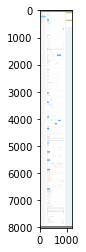

In [37]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Elements packs").click()
    driver.find_element_by_link_text("Bootstrap form").click()
    sleep(15.0)
        
    maximize_window(driver=driver)
    sleep(15.0)
    
    _img = screenshot(driver, save_to_file='dataset/images/bootstrap-form.png')
    print(_img.shape)
    plt.imshow(_img)
    sleep(15.0)
        
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/bootstrap-form.parquet')
    
    with open('dataset/html/bootstrap-form.html', 'wb') as f:
        f.write(driver.page_source.encode())
        f.flush()
  

## Bootstarp forms

Window maximized
(1397, 1200, 4)
Number of discovered elements: 312


  0%|          | 0/312 [00:00<?, ?it/s]

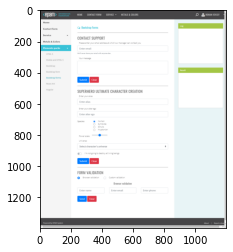

In [38]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Elements packs").click()
    driver.find_element_by_link_text("Bootstrap forms").click()
    sleep(15.0)
        
    maximize_window(driver=driver)
    sleep(15.0)
    
    _img = screenshot(driver, save_to_file='dataset/images/bootstrap-forms.png')
    print(_img.shape)
    plt.imshow(_img)
    sleep(15.0)
        
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/bootstrap-forms.parquet')
    
    with open('dataset/html/bootstrap-forms.html', 'wb') as f:
        f.write(driver.page_source.encode())
        f.flush()


In [39]:
print('Elapsed time:', datetime.now() - START_TS)

Elapsed time: 5:17:01.637805
